## Generate word2vec embeddings using TensorFlow

Use Noise Contrastive Estimator (NCE) as a loss function

Modified from original code here: http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/

#### Some imports to make code compatible with Python 2 as well as 3

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import collections
import math
import os
import random
import zipfile

In [3]:
from six.moves import urllib
from six.moves import xrange

In [4]:
import numpy as np
import tensorflow as tf

In [5]:
print(np.__version__)
print(tf.__version__)

1.23.5
2.12.0


In [6]:
DOWNLOADED_FILENAME = 'SampleText.zip'

def maybe_download(url_path, expected_bytes):
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(url_path, DOWNLOADED_FILENAME)
    statinfo = os.stat(DOWNLOADED_FILENAME)

    if statinfo.st_size == expected_bytes:
        print('Found and verified file from this path: ', url_path)
        print('Downloaded file: ', DOWNLOADED_FILENAME)
    else:
        print(statinfo.st_size)

        raise Exception(
            'Failed to verify file from: ' + url_path + '. Can you get to it with a browser?')

In [7]:
def read_words():
    with zipfile.ZipFile(DOWNLOADED_FILENAME) as f:
        firstfile = f.namelist()[0]
        filestring = tf.compat.as_str(f.read(firstfile))
        words = filestring.split()
    
    return words

In [8]:
URL_PATH = 'http://mattmahoney.net/dc/text8.zip'
FILESIZE = 31344016

maybe_download(URL_PATH, FILESIZE)

Found and verified file from this path:  http://mattmahoney.net/dc/text8.zip
Downloaded file:  SampleText.zip


#### Get the list of words from the the sample, this is our entire vocabulary

In [9]:
vocabulary = read_words()

In [10]:
len(vocabulary)

17005207

In [11]:
vocabulary[:25]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes']

### Build the data set used to generate word2vec embeddings

* *words* A list of all words in the input dataset
* *n_words* The number of words to include in the dataset. We use the most frequently occurring n_words

Return values are:

* *word_counts* The most frequently occurring words and the corresponding frequencies
* *word_indexes* The list of index values which uniquely identifies each word in the dataset
* *dictionary* Mapping from a word to its unique index
* *reversed_dictionary* Mapping from the unique index to the word

In [12]:
def build_dataset(words, n_words):
    word_counts = [['UNKNOWN', -1]]
    
    counter = collections.Counter(words)
    word_counts.extend(counter.most_common(n_words - 1))
 
    # Only the most common words are added to the dictionary
    dictionary = dict()
    
    for word, _ in word_counts:
        # The current length of the dictionary is the unique index of this word
        # added to the dictionary
        dictionary[word] = len(dictionary)
    
    word_indexes = list()
    
    unknown_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNKNOWN']
            unknown_count += 1
        
        word_indexes.append(index)
    
    # Count of unknown words
    word_counts[0][1] = unknown_count
    
    # Map from unique indexes to word
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    return  word_counts, word_indexes, dictionary, reversed_dictionary

In [13]:
VOCABULARY_SIZE = 10000

word_counts, word_indexes, dictionary, reversed_dictionary = build_dataset(vocabulary, VOCABULARY_SIZE)

In [14]:
word_counts[:10]

[['UNKNOWN', 1737307],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [15]:
word_indexes[:10]

[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]

In [17]:
for key in random.sample(sorted(dictionary), 10):
    print(key, ":", dictionary[key])

linear : 1477
socialism : 4369
connecticut : 4514
holy : 839
monastery : 5068
accompanied : 3456
rebels : 6149
evil : 1768
christians : 1420
karl : 2771


In [18]:
for key in random.sample(sorted(reversed_dictionary), 10):
    print(key, ":", reversed_dictionary[key])

218 : population
791 : give
7482 : braves
4661 : lion
1362 : keep
9074 : confession
7733 : mph
3628 : bringing
2481 : stands
6338 : messiah


#### A hint to the Python interpreter that vocabulary can be deleted

In [19]:
del vocabulary

### Return one batch of data and the corresponding labels for training

* *word_indexes* A list of unique indexes which identifies each word in the dataset. The most popular words have the lowest index values
* *batch_size* The number of elements in each batch
* *num_skips* The number of words to choose from the neighboring words within the skip_window. Each input word will appear num_skips times in the batch with a context or neighboring word as the corresponding label
* *skip_window* How many words to consider around one input word

In [20]:
# Global index into words maintained across batches
global_index = 0

def generate_batch(word_indexes, batch_size, num_skips, skip_window):
    global global_index

    # For every input we find num_skips context words within a window
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    # batch = [1, 2, 3, .... batch_size]
    # labels = [[1], [2], [3], ..., [batch_size]]
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # The span of a window includes the skip_window elements on each side
    # of the input word plus the word itself
    span = 2 * skip_window + 1  # [ skip_window input_word skip_window ]

    # A deque is double-ended queue which supports memory efficient appends
    # and pops from each side
    buffer = collections.deque(maxlen=span)

    # Initialize the deque with the first words in the deque
    for _ in range(span):
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
    
    for i in range(batch_size // num_skips):
        target = skip_window  # input word at the center of the buffer
        targets_to_avoid = [skip_window]

        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            
            batch[i * num_skips + j] = buffer[skip_window]  # this is the input word
            labels[i * num_skips + j, 0] = buffer[target]  # these are the context words
        
        # The first word from the buffer is removed automatically when a new word
        # is added in at the end
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
    
    # Backtrack a little bit to avoid skipping words in the end of a batch, these
    # words will be captured in the next batch
    global_index = (global_index + len(word_indexes) - span) % len(word_indexes)

    return batch, labels

In [21]:
batch, labels = generate_batch(word_indexes, 10, 2, 5)            #skip_window = 2x num skip +1 

In [22]:
batch

array([   2,    2, 3134, 3134,   46,   46,   59,   59,  156,  156])

In [23]:
labels

array([[128],
       [195],
       [156],
       [ 12],
       [  2],
       [  6],
       [156],
       [ 46],
       [134],
       [195]])

In [24]:
for i in range(9):
    print(reversed_dictionary[batch[i]], ": ", reversed_dictionary[labels[i][0]])

of :  early
of :  term
abuse :  against
abuse :  as
first :  of
first :  a
used :  against
used :  first
against :  including


### Initialize some variables to build and train the skip-gram model

* *batch_size*: The size of the batch to use in training
* *embedding_size*: Dimensions of the embedding vector i.e. how many features we use to represent a word
* *skip_window*: How many words to include in the context, this is to the left and right
* *num_skips*: How many context words to associate with each target word

In [25]:
batch_size = 128
embedding_size = 50
skip_window = 2
num_skips = 2

# Reset the global index because we updated while testing the batch code
global_index = 0

### Choose some words at random to validate our trained model

* *valid_size*: Number of words to evaluate our model, we'll use these words to see how similar the closest words are
* *valid_window*: The window from where we draw the words to run validation on, only pick from the most commonly used words

Choose the set of words from the top 100 at random

In [26]:
valid_size = 16  
valid_window = 100

valid_examples = np.random.choice(valid_window, valid_size, replace=False)

### Number of negative examples to sample for NCE loss calculation

In [27]:
num_samples = 64

### Input placeholder to feed data in batches

In [31]:
#tf.reset_default_graph()
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
train_inputs = tf.compat.v1.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.compat.v1.placeholder(tf.int32, shape=[batch_size, 1])

### Set up a constant to hold validation data

In [32]:
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Embeddings are word representations that will be generated by word2vec

Initialize a variable to hold the embeddings and embeddings for specific words can be accessed using *tf.nn.embedding_lookup*

NOTE: Embeddings and NCE losses only work on the CPU in TensorFlow, GPU support has not been added yet

In [36]:
embeddings = tf.compat.v1.Variable(
    tf.compat.v1.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))
embed = tf.compat.v1.nn.embedding_lookup(embeddings, train_inputs)

### Construct weights and biases to hold the NCE (Noise Contrastive Estimation) loss

In [37]:
nce_weights = tf.compat.v1.Variable(
    tf.compat.v1.truncated_normal([VOCABULARY_SIZE, embedding_size],
                        stddev=1.0 / math.sqrt(embedding_size)))
nce_biases = tf.compat.v1.Variable(tf.compat.v1.zeros([VOCABULARY_SIZE]))

In [38]:
loss = tf.compat.v1.reduce_mean(
      tf.compat.v1.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_samples,
                     num_classes=VOCABULARY_SIZE))

In [39]:
 optimizer = tf.compat.v1.train.GradientDescentOptimizer(1.0).minimize(loss)

### Normalize the embeddings vector to calculate cosine similarity between words

*normalized_vector = vector / L2 norm of vector*

In [40]:
l2_norm = tf.compat.v1.sqrt(tf.compat.v1.reduce_sum(tf.compat.v1.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / l2_norm

Instructions for updating:
keep_dims is deprecated, use keepdims instead


#### Look up the normalized embeddings of the words we use to validate our model

In [41]:
valid_embeddings = tf.compat.v1.nn.embedding_lookup(normalized_embeddings, valid_dataset)

#### Find the cosine similarity of the validation words against all words in our vocabulary

In [42]:
similarity = tf.compat.v1.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [43]:
init = tf.compat.v1.global_variables_initializer()

In [46]:
num_steps = 200000

In [47]:
final_embeddings = None

with tf.compat.v1.Session() as session:
    init.run()

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            word_indexes, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 20000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
            print("\n")
            
    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  208.41558837890625
Nearest to up: embryo, gutenberg, bios, scheme, tr, panic, michael, czech,
Nearest to he: nehru, rick, quit, khmer, valued, theologian, recordings, knife,
Nearest to in: allegations, indication, bottom, designed, tournament, elf, crude, honors,
Nearest to their: expensive, tuberculosis, nobel, chronicle, hood, funding, insufficient, equally,
Nearest to seven: birmingham, interestingly, stationary, collection, raised, topics, prose, exercise,
Nearest to nine: weber, whereby, equatorial, warren, abc, organizations, nicknamed, producer,
Nearest to about: synonym, topic, mongols, chorus, consumption, biography, assembled, card,
Nearest to i: teaches, minimum, baltic, nintendo, lovecraft, px, employ, benefit,
Nearest to this: fierce, defender, identification, exceptions, strands, grown, wells, contested,
Nearest to new: gm, young, involved, regarded, visits, studios, bonding, arctic,
Nearest to all: simon, maya, addiction, shape, chaplin, yahoo,

Average loss at step  88000 :  4.6474574949741365
Average loss at step  90000 :  4.653382545232772
Average loss at step  92000 :  4.602448752641678
Average loss at step  94000 :  4.659208746314048
Average loss at step  96000 :  4.657764727175236
Average loss at step  98000 :  4.655171925306321
Average loss at step  100000 :  4.643854025006294
Nearest to up: them, out, adds, attempt, able, pass, suspect, help,
Nearest to he: she, it, they, who, coordinates, nehru, accessed, applies,
Nearest to in: during, mit, through, into, themes, from, within, until,
Nearest to their: its, his, the, both, him, ceased, her, absorb,
Nearest to seven: eight, six, five, four, three, nine, zero, one,
Nearest to nine: eight, seven, six, five, four, three, zero, one,
Nearest to about: tanker, jamal, culturally, on, mohammed, leslie, complaints, dense,
Nearest to i: serve, pro, confusion, g, mann, crew, seems, rookie,
Nearest to this: it, which, that, generally, bios, any, now, an,
Nearest to new: sk, arctic

Average loss at step  186000 :  4.622649670839309
Average loss at step  188000 :  4.615363111376762
Average loss at step  190000 :  4.312667835354805
Average loss at step  192000 :  4.264947722315788
Average loss at step  194000 :  4.422503976106643
Average loss at step  196000 :  4.490877939105034
Average loss at step  198000 :  4.563229387879372


In [48]:
def save_words_embeddings(embeddings, word_counts):
    
    np.save('embeddings.npy', embeddings)
    
    words = [x[0] for x in word_counts]
    np.save('words.npy', words)
    
save_words_embeddings(final_embeddings, word_counts)

### Visualize the embeddings

In [49]:
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'

    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)

        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)
    plt.show(filename)

In [50]:
from sklearn.manifold import TSNE
NUM_PLOT_POINTS = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')

low_dim_embs = tsne.fit_transform(final_embeddings[:NUM_PLOT_POINTS, :])

labels = [reversed_dictionary[i] for i in xrange(NUM_PLOT_POINTS)]

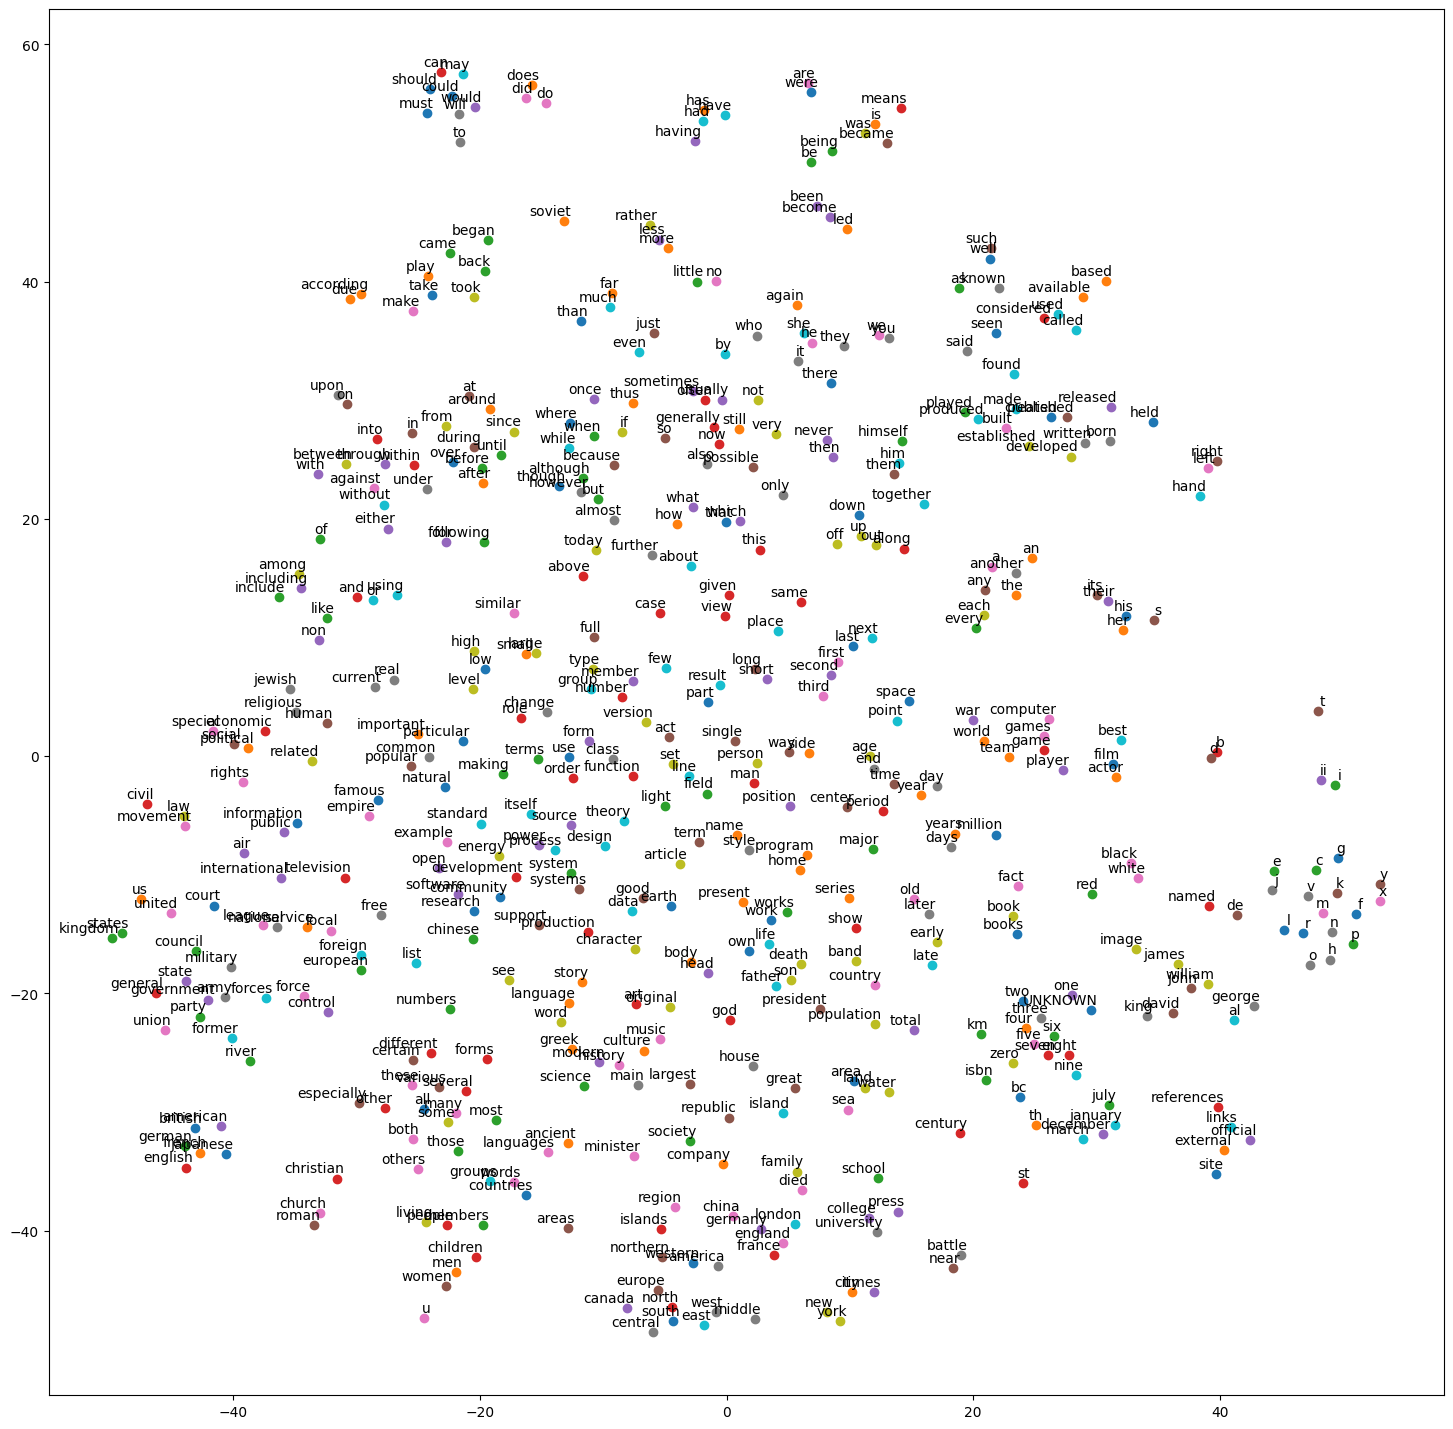

In [51]:
plot_with_labels(low_dim_embs, labels)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import collections
import math
import os
import random
import tarfile
import re

In [3]:
from six.moves import urllib

In [4]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
print(np.__version__)
print(mp.__version__)
print(tf.__version__)

1.13.1
2.0.2
1.3.0


#### Download, unzip and untar files in an automated way

In [6]:
DOWNLOADED_FILENAME = 'ImdbReviews.tar.gz'

def download_file(url_path):
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(url_path, DOWNLOADED_FILENAME)

    print('Found and verified file from this path: ', url_path)
    print('Downloaded file: ', DOWNLOADED_FILENAME)

### Extract reviews and the corresponding positive and negative labels from the dataset

In [7]:
TOKEN_REGEX = re.compile("[^A-Za-z0-9 ]+")


def get_reviews(dirname, positive=True):
    label = 1 if positive else 0

    reviews = []
    labels = []
    for filename in os.listdir(dirname):
        if filename.endswith(".txt"):
            with open(dirname + filename, 'r+') as f:
                review = f.read().decode('utf-8')
                review = review.lower().replace("<br />", " ")
                review = re.sub(TOKEN_REGEX, '', review)
                
                reviews.append(review)
                labels.append(label)
    
    return reviews, labels           

def extract_labels_data():
    # If the file has not already been extracted
    if not os.path.exists('aclImdb'):
        with tarfile.open(DOWNLOADED_FILENAME) as tar:
            tar.extractall()
            tar.close()
        
    positive_reviews, positive_labels = get_reviews("aclImdb/train/pos/", positive=True)
    negative_reviews, negative_labels = get_reviews("aclImdb/train/neg/", positive=False)

    data = positive_reviews + negative_reviews
    labels = positive_labels + negative_labels

    return labels, data

In [8]:
URL_PATH = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

download_file(URL_PATH)

Found and verified file from this path:  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Downloaded file:  ImdbReviews.tar.gz


In [9]:
labels, data = extract_labels_data()

In [10]:
labels[:5]

[1, 1, 1, 1, 1]

In [11]:
data[:5]

[u'bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell highs satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled  at  high a classic line inspector im here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isnt',
 u'homelessness or houselessness as george carlin stated has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school work or vote for the matter mo

In [12]:
len(labels), len(data)

(25000, 25000)

In [13]:
max_document_length = max([len(x.split(" ")) for x in data])
print(max_document_length)

2470


### How many words to consider in each review?

Majority of the reviews fall under 250 words. This a number we've chosen based on some analysis of the data:

* Count the number of words in each file and divide by number of files to get an average i.e. **avg_words_per_file = total_words / num_files**
* Plot the words per file on matplot lib and try find a number which includes a majority of files

Word embeddings all have the same dimensionality which you can specify. A document is a vector of word embeddings (one dbpedia instance is a document in this case)

* Each document should be of the **same length**, documents longer than the MAX_SEQUENCE_LENGTH are truncated to this length
* The other documents will be **padded** by a special symbol to be the same max length

In [14]:
MAX_SEQUENCE_LENGTH = 250

### Vocabulary processor
 
http://tflearn.org/data_utils/
 
Library to map every word which occurs in our dataset to a unique identifer. If there are 10023 words each will be assigned a unique id from 1-10023

In [15]:
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(MAX_SEQUENCE_LENGTH)

#### Transform every word to a representation using unique ids

In [16]:
x_data = np.array(list(vocab_processor.fit_transform(data)))
y_output = np.array(labels)

vocabulary_size = len(vocab_processor.vocabulary_)
print(vocabulary_size)

111526


In [17]:
data[3:5]

[u'this is easily the most underrated film inn the brooks cannon sure its flawed it does not give a realistic view of homelessness unlike say how citizen kane gave a realistic view of lounge singers or titanic gave a realistic view of italians you idiots many of the jokes fall flat but still this film is very lovable in a way many comedies are not and to pull that off in a story about some of the most traditionally reviled members of society is truly impressive its not the fisher king but its not crap either my only complaint is that brooks should have cast someone else in the lead i love mel as a director and writer not so much as a lead',
 u'this is not the typical mel brooks film it was much less slapstick than most of his movies and actually had a plot that was followable leslie ann warren made the movie she is such a fantastic underrated actress there were some moments that could have been fleshed out a bit more and some scenes that could probably have been cut to make the room to

In [18]:
x_data[3:5]

array([[290,   3, 364,  10, 121, 365, 291, 366,  10, 168, 367, 368, 162,
        369,   7, 370, 243, 286,   4, 371, 372,  53,  92, 373, 374, 375,
        376, 377, 378,   4, 371, 372,  53, 379, 380,  93, 381, 378,   4,
        371, 372,  53, 382, 146, 383,  83,  53,  10, 384, 385, 386, 103,
        387, 290, 291,   3, 388, 389,  25,   4, 390,  83, 391, 238, 243,
         61,  30, 392,  32, 206,  25,   4, 393,  17,  14,  53,  10, 121,
        394, 395, 396,  53, 397,   3, 398, 399, 162, 243,  10, 400, 401,
        103, 162, 243, 402, 403,  22, 404, 405,   3,  32, 168, 285, 301,
        406, 407, 408,  25,  10,  28,  59, 252, 167,  13,   4, 409,  61,
        410, 243, 411,  35,  13,   4,  28,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [19]:
x_data[:2]

array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  13,  21,  22,  23,  24,  25,
         10,  26,  27,  28,  29,  30,  31,  32,   1,  33,  34,   3,  35,
         36,  30,  37,  38,   3,  21,  10,  39,  30,  40,  41,  10,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  21,  51,  10,  52,  53,
         10,  54,  55,  56,  57,  29,  53,  10,  58,  59,  60,  61,  49,
         43,  62,  59,  63,  10,  64,  25,  65,   4,  66,  67,  68,  30,
         69,  70,  10,  18,  59,  71,  72,   9,   2,   4,  73,  74,  75,
         76,  77,  30,  78,  79,  53,  80,  21,  66,  81,  30,   1,   2,
         59,  82,  32,  83,  84,  53,  22,  85,  86,  32,   1,   2,   3,
         87,  88,  89,   4,  90,  32,   7,  91,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [20]:
y_output[:5]

array([1, 1, 1, 1, 1])

#### Shuffle the data so the training instances are randomly fed to the RNN

In [21]:
np.random.seed(22)
shuffle_indices = np.random.permutation(np.arange(len(x_data)))

x_shuffled = x_data[shuffle_indices]
y_shuffled = y_output[shuffle_indices]

In [22]:
TRAIN_DATA = 5000
TOTAL_DATA = 6000

train_data = x_shuffled[:TRAIN_DATA]
train_target = y_shuffled[:TRAIN_DATA]

test_data = x_shuffled[TRAIN_DATA:TOTAL_DATA]
test_target = y_shuffled[TRAIN_DATA:TOTAL_DATA]

In [23]:
tf.reset_default_graph()

x = tf.placeholder(tf.int32, [None, MAX_SEQUENCE_LENGTH])
y = tf.placeholder(tf.int32, [None])

In [24]:
num_epochs = 20
batch_size = 25
embedding_size = 50
max_label = 2

### Embeddings to represent words

These embeddings are generated as a part of the training process of the RNN. The embeddings are trained using the reviews in the training dataset.

* *embedding_matrix* This is a matrix which holds the embeddings for every word in the vocabulary. The values are determined during the training process
* *embeddings* The embeddings for the words which are input as a part of one training batch

In [25]:
embedding_matrix = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
embeddings = tf.nn.embedding_lookup(embedding_matrix, x)

In [26]:
embedding_matrix

<tf.Variable 'Variable:0' shape=(111526, 50) dtype=float32_ref>

In [27]:
embeddings

<tf.Tensor 'embedding_lookup:0' shape=(?, 250, 50) dtype=float32>

In [28]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(embedding_size)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)

### Results from an RNN of LSTM cells

(ouput, (**final_state**, other_state_info))

We're interested in the final state of this RNN because those are the encodings we feed into the prediction layer of our neural network

In [32]:
_, (encoding, _) = tf.nn.dynamic_rnn(lstmCell, embeddings, dtype=tf.float32)

In [33]:
encoding

<tf.Tensor 'rnn_1/while/Exit_2:0' shape=(?, 50) dtype=float32>

#### A densely connected prediction layer

* *activation=None* because the activation will be part of the tf.nn.sparse_softmax_cross_entropy_with_logits
* *cross_entropy* the loss function for probability distributions
* *max_label* the number of outputs of the prediction layer, here is 2, positive or negative

In [34]:
logits = tf.layers.dense(encoding, max_label, activation=None)

In [35]:
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(cross_entropy)

#### Find the output with the highest probability and compare against the true label

In [36]:
prediction = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

In [37]:
optimizer = tf.train.AdamOptimizer(0.01)
train_step = optimizer.minimize(loss)

In [38]:
init = tf.global_variables_initializer()

In [39]:
with tf.Session() as session:
    init.run()
    
    for epoch in range(num_epochs):
        
        num_batches = int(len(train_data) // batch_size) + 1
        
        for i in range(num_batches):
            # Select train data
            min_ix = i * batch_size
            max_ix = np.min([len(train_data), ((i+1) * batch_size)])

            x_train_batch = train_data[min_ix:max_ix]
            y_train_batch = train_target[min_ix:max_ix]
            
            train_dict = {x: x_train_batch, y: y_train_batch}
            session.run(train_step, feed_dict=train_dict)
            
            train_loss, train_acc = session.run([loss, accuracy], feed_dict=train_dict)

        test_dict = {x: test_data, y: test_target}
        test_loss, test_acc = session.run([loss, accuracy], feed_dict=test_dict)    
        print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.5}'.format(epoch + 1, test_loss, test_acc)) 

Epoch: 1, Test Loss: 0.69, Test Acc: 0.49
Epoch: 2, Test Loss: 0.8, Test Acc: 0.505
Epoch: 3, Test Loss: 0.83, Test Acc: 0.602
Epoch: 4, Test Loss: 0.8, Test Acc: 0.731
Epoch: 5, Test Loss: 1.1, Test Acc: 0.759
Epoch: 6, Test Loss: 1.3, Test Acc: 0.774
Epoch: 7, Test Loss: 1.3, Test Acc: 0.796
Epoch: 8, Test Loss: 1.3, Test Acc: 0.797
Epoch: 9, Test Loss: 1.4, Test Acc: 0.799
Epoch: 10, Test Loss: 1.5, Test Acc: 0.809
Epoch: 11, Test Loss: 1.5, Test Acc: 0.813
Epoch: 12, Test Loss: 1.5, Test Acc: 0.813
Epoch: 13, Test Loss: 1.6, Test Acc: 0.813
Epoch: 14, Test Loss: 1.6, Test Acc: 0.814
Epoch: 15, Test Loss: 1.6, Test Acc: 0.819
Epoch: 16, Test Loss: 1.7, Test Acc: 0.82
Epoch: 17, Test Loss: 1.7, Test Acc: 0.82
Epoch: 18, Test Loss: 1.8, Test Acc: 0.82
Epoch: 19, Test Loss: 1.8, Test Acc: 0.818
Epoch: 20, Test Loss: 1.9, Test Acc: 0.819


## Sentiment Analysis of Reviews using RNNs in TensorFlow, with pre-built embeddings

Modified from original code here: https://github.com/adeshpande3/LSTM-Sentiment-Analysis/blob/master/Oriole%20LSTM.ipynb

#### Some imports to make code compatible with Python 2 as well as 3

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import collections
import math
import os
import random
import tarfile
import re

In [3]:
from six.moves import urllib

In [4]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
print(np.__version__)
print(mp.__version__)
print(tf.__version__)

1.13.1
2.0.2
1.3.0


#### Download, unzip and untar files in an automated way

In [6]:
DOWNLOADED_FILENAME = 'ImdbReviews.tar.gz'

def download_file(url_path):
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(url_path, DOWNLOADED_FILENAME)

    print('Found and verified file from this path: ', url_path)
    print('Downloaded file: ', DOWNLOADED_FILENAME)

### Extract reviews and the corresponding positive and negative labels from the dataset

In [7]:
TOKEN_REGEX = re.compile("[^A-Za-z0-9 ]+")


def get_reviews(dirname, positive=True):
    label = 1 if positive else 0

    reviews = []
    labels = []
    for filename in os.listdir(dirname):
        if filename.endswith(".txt"):
            with open(dirname + filename, 'r+') as f:
                review = f.read().decode('utf-8')
                review = review.lower().replace("<br />", " ")
                review = re.sub(TOKEN_REGEX, '', review)
                
                reviews.append(review)
                labels.append(label)
    
    return reviews, labels           

def extract_labels_data():
    # If the file has not already been extracted
    if not os.path.exists('aclImdb'):
        with tarfile.open(DOWNLOADED_FILENAME) as tar:
            tar.extractall()
            tar.close()
        
    positive_reviews, positive_labels = get_reviews("aclImdb/train/pos/", positive=True)
    negative_reviews, negative_labels = get_reviews("aclImdb/train/neg/", positive=False)

    data = positive_reviews + negative_reviews
    labels = positive_labels + negative_labels

    return labels, data

In [8]:
URL_PATH = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

download_file(URL_PATH)

Found and verified file from this path:  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Downloaded file:  ImdbReviews.tar.gz


In [9]:
labels, data = extract_labels_data()

In [10]:
labels[:5]

[1, 1, 1, 1, 1]

In [11]:
data[:5]

[u'bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell highs satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled  at  high a classic line inspector im here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isnt',
 u'homelessness or houselessness as george carlin stated has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school work or vote for the matter mo

In [12]:
len(labels), len(data)

(25000, 25000)

In [13]:
max_document_length = max([len(x.split(" ")) for x in data])
print(max_document_length)

2470


### How many words to consider in each review?

Majority of the reviews fall under 250 words. This a number we've chosen based on some analysis of the data:

* Count the number of words in each file and divide by number of files to get an average i.e. **avg_words_per_file = total_words / num_files**
* Plot the words per file on matplot lib and try find a number which includes a majority of files

Word embeddings all have the same dimensionality which you can specify. A document is a vector of word embeddings (one dbpedia instance is a document in this case)

* Each document should be of the **same length**, documents longer than the MAX_SEQUENCE_LENGTH are truncated to this length
* The other documents will be **padded** by a special symbol to be the same max length

In [14]:
MAX_SEQUENCE_LENGTH = 250

### Use a pre-trained model for embeddings

Instead of training our model on our own dataset we will use a pre-trained model.

This is much better because these word vectors will be more generalized as they have been trained on a different dataset. These embeddings are trained using GloVe, a vector generation model very simalar to word2vec. 

In [15]:
words = np.load('wordsList.npy')

In [16]:
words[:5], len(words)

(array(['0', ',', '.', 'of', 'to'],
       dtype='|S68'), 400000)

### Map every word to a unique index

The words are in the order and the position of the word in the word list is its index.

In [17]:
def get_word_index_dictionary(words):
    
    dictionary = {}
    
    index = 0
    for word in words:
        dictionary[word] = index
        index += 1
    
    return dictionary

dictionary = get_word_index_dictionary(words)        

#### The most common words have lower index values

In [18]:
dictionary['and'], dictionary['this'], dictionary['together'], dictionary['supreme']

(5, 37, 600, 1399)

### Convert the sentences so they're represented in the form of word indexes

Use the word index mapping that we created earlier in order to look up the index for individual words

In [19]:
review_ids = []

def convert_reviews_to_ids(data, words):
    words_list = words.tolist()

    progress = 0
    for review in data:
        review_id = []
        
        index = 0
        for word in review:
            if index >= MAX_SEQUENCE_LENGTH:
                break;
            
            try:
                review_id.append(dictionary[word])
            except KeyError:
                review_id.append(0)
            
            index += 1
        if len(review_id) < MAX_SEQUENCE_LENGTH:
            review_id = np.pad(review_id, (0, MAX_SEQUENCE_LENGTH - index), 'constant')

        review_ids.append(np.array(review_id))
        progress += 1
        
        if progress % 1000 == 0:
            print("Completed: ", progress)

In [20]:
convert_reviews_to_ids(data, words)

Completed:  1000
Completed:  2000
Completed:  3000
Completed:  4000
Completed:  5000
Completed:  6000
Completed:  7000
Completed:  8000
Completed:  9000
Completed:  10000
Completed:  11000
Completed:  12000
Completed:  13000
Completed:  14000
Completed:  15000
Completed:  16000
Completed:  17000
Completed:  18000
Completed:  19000
Completed:  20000
Completed:  21000
Completed:  22000
Completed:  23000
Completed:  24000
Completed:  25000


In [21]:
review_ids[19825]

array([1556, 1110,   41, 3814, 3410,    0, 1534,    0, 1864, 5025, 6479,
       1556,    0, 1534, 1110, 2404, 1110, 3814,    0, 2159, 5918, 1110,
          0, 3880,   41, 5025, 1993,    0,    7, 5025, 1911, 1110,    7,
       1968, 3524,    0, 1556, 4868, 4868, 1534, 2159, 1534,    0,    7,
       3814,    0, 1110, 1864, 1534, 2159,    7, 2159,   41, 1864,    0,
          7, 2159, 1993, 4868, 1534, 3420, 5918, 1110, 1911, 1110,    0,
       1556, 6479, 2159,    0, 1534, 1110, 1911,   41, 4868, 6479, 1534,
       5025, 3524,    0, 4868, 3420, 1911,    7, 5918,    0, 5918,    7,
       1534,    0,    7,    0, 3420, 4868,   41, 3814, 2159,    0, 5140,
       5918, 1110, 3814,    0, 1864, 5025,    7,   41, 1993,   41, 3814,
       3410,    0, 1968, 4868, 3814, 2159,    0, 3410, 4868,    0, 2159,
       5918, 1110, 1911, 1110,    0, 3410,   41, 1911, 5025,    0, 1534,
       3420,   41, 1864, 1110,    0, 5140, 4868, 1911, 5025, 1968,    0,
       1534, 6479, 1968, 1968, 1110, 3814, 5025, 35

### Load this saved file to get the reviews in the IMDB dataset represented using word indexes

These have been pre-calculated and saved, and will help you if your id mapping code takes too long to run

In [22]:
review_ids = np.load('idsMatrix.npy')

In [23]:
review_ids.shape

(25000, 250)

In [24]:
review_ids[:5]

array([[174943,    152,     14, ...,      0,      0,      0],
       [ 26494,     46, 399999, ...,   2153,    144,      7],
       [  6520, 399999,     21, ...,      0,      0,      0],
       [    37,     14,   2407, ...,      0,      0,      0],
       [    37,     14,     36, ...,      0,      0,      0]], dtype=int32)

In [25]:
x_data = review_ids
y_output = np.array(labels)

vocabulary_size = len(words)
print(vocabulary_size)

400000


In [26]:
data[3:5]

[u'this is easily the most underrated film inn the brooks cannon sure its flawed it does not give a realistic view of homelessness unlike say how citizen kane gave a realistic view of lounge singers or titanic gave a realistic view of italians you idiots many of the jokes fall flat but still this film is very lovable in a way many comedies are not and to pull that off in a story about some of the most traditionally reviled members of society is truly impressive its not the fisher king but its not crap either my only complaint is that brooks should have cast someone else in the lead i love mel as a director and writer not so much as a lead',
 u'this is not the typical mel brooks film it was much less slapstick than most of his movies and actually had a plot that was followable leslie ann warren made the movie she is such a fantastic underrated actress there were some moments that could have been fleshed out a bit more and some scenes that could probably have been cut to make the room to

In [27]:
x_data[3:5]

array([[    37,     14,   2407, 201534,     96,  37314,    319,   7158,
        201534,   6469,   8828,   1085,     47,   9703,     20,    260,
            36,    455,      7,   7284,   1139,      3,  26494,   2633,
           203,    197,   3941,  12739,    646,      7,   7284,   1139,
             3,  11990,   7792,     46,  12608,    646,      7,   7284,
          1139,      3,   8593,     81,  36381,    109,      3, 201534,
          8735,    807,   2983,     34,    149,     37,    319,     14,
           191,  31906,      6,      7,    179,    109,  15402,     32,
            36,      5,      4,   2933,     12,    138,      6,      7,
           523,     59,     77,      3, 201534,     96,   4246,  30006,
           235,      3,    908,     14,   4702,   4571,     47,     36,
        201534,   6429,    691,     34,     47,     36,  35404,    900,
           192,     91,   4499,     14,     12,   6469,    189,     33,
          1784,   1318,   1726,      6, 201534,    410,     41, 

In [28]:
y_output[:5]

array([1, 1, 1, 1, 1])

#### Shuffle the data so the training instances are randomly fed to the RNN

In [29]:
np.random.seed(22)
shuffle_indices = np.random.permutation(np.arange(len(x_data)))

x_shuffled = x_data[shuffle_indices]
y_shuffled = y_output[shuffle_indices]

In [30]:
TRAIN_DATA = 5000
TOTAL_DATA = 6000

train_data = x_shuffled[:TRAIN_DATA]
train_target = y_shuffled[:TRAIN_DATA]

test_data = x_shuffled[TRAIN_DATA:TOTAL_DATA]
test_target = y_shuffled[TRAIN_DATA:TOTAL_DATA]

In [31]:
tf.reset_default_graph()

x = tf.placeholder(tf.int32, [None, MAX_SEQUENCE_LENGTH])
y = tf.placeholder(tf.int32, [None])

In [32]:
batch_size = 25
embedding_size = 50
max_label = 2

### Embeddings to represent words

These embeddings have been pre-built using GloVe a word vector embedding algorithm just like word2vec. The matrix will contain 400,000 word vectors, each with a dimensionality of 50.

* *saved_embeddings* This is a matrix which holds the embeddings for every word in the vocabulary. The values have been pre-loaded and were generated using the GloVe algorithm
* *embeddings* The embeddings for the words which are input as a part of one training batch

In [33]:
saved_embeddings = np.load('wordVectors.npy')
embeddings = tf.nn.embedding_lookup(saved_embeddings, x)

In [34]:
saved_embeddings

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.013441  ,  0.23682   , -0.16899   , ..., -0.56656998,
         0.044691  ,  0.30392   ],
       [ 0.15164   ,  0.30177   , -0.16763   , ..., -0.35652   ,
         0.016413  ,  0.10216   ],
       ..., 
       [-0.51181   ,  0.058706  ,  1.09130001, ..., -0.25003001,
        -1.125     ,  1.58630002],
       [-0.75897998, -0.47426   ,  0.47369999, ...,  0.78953999,
        -0.014116  ,  0.64480001],
       [-0.79149002,  0.86616999,  0.11998   , ..., -0.29995999,
        -0.0063003 ,  0.39539999]], dtype=float32)

In [35]:
embeddings

<tf.Tensor 'embedding_lookup:0' shape=(?, 250, 50) dtype=float32>

In [36]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(embedding_size)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)

### Results from an RNN of LSTM cells

(ouput, (**final_state**, other_state_info))

We're interested in the final state of this RNN because those are the encodings we feed into the prediction layer of our neural network

In [37]:
_, (encoding, _) = tf.nn.dynamic_rnn(lstmCell, embeddings, dtype=tf.float32)

In [38]:
encoding

<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 50) dtype=float32>

#### A densely connected prediction layer

* *activation=None* because the activation will be part of the tf.nn.sparse_softmax_cross_entropy_with_logits
* *cross_entropy* the loss function for probability distributions
* *max_label* the number of outputs of the prediction layer, here is 2, positive or negative

In [39]:
logits = tf.layers.dense(encoding, max_label, activation=None)

In [40]:
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(cross_entropy)

#### Find the output with the highest probability and compare against the true label

In [41]:
prediction = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

In [42]:
optimizer = tf.train.AdamOptimizer(0.01)
train_step = optimizer.minimize(loss)

In [ ]:
num_epochs = 20

In [43]:
init = tf.global_variables_initializer()

In [44]:
with tf.Session() as session:
    init.run()
    
    for epoch in range(num_epochs):
        
        num_batches = int(len(train_data) // batch_size) + 1
        
        for i in range(num_batches):
            # Select train data
            min_ix = i * batch_size
            max_ix = np.min([len(train_data), ((i+1) * batch_size)])

            x_train_batch = train_data[min_ix:max_ix]
            y_train_batch = train_target[min_ix:max_ix]
            
            train_dict = {x: x_train_batch, y: y_train_batch}
            
            
            session.run(train_step, feed_dict=train_dict)
            
            train_loss, train_acc = session.run([loss, accuracy], feed_dict=train_dict)

        test_dict = {x: test_data, y: test_target}
        test_loss, test_acc = session.run([loss, accuracy], feed_dict=test_dict)    
        print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.5}'.format(epoch + 1, test_loss, test_acc)) 

Epoch: 1, Test Loss: 0.69, Test Acc: 0.498
Epoch: 2, Test Loss: 0.7, Test Acc: 0.502
Epoch: 3, Test Loss: 0.71, Test Acc: 0.509
Epoch: 4, Test Loss: 0.7, Test Acc: 0.516
Epoch: 5, Test Loss: 0.73, Test Acc: 0.493
Epoch: 6, Test Loss: 0.57, Test Acc: 0.747
Epoch: 7, Test Loss: 0.54, Test Acc: 0.752
Epoch: 8, Test Loss: 0.55, Test Acc: 0.767
Epoch: 9, Test Loss: 0.56, Test Acc: 0.78
Epoch: 10, Test Loss: 0.59, Test Acc: 0.783
Epoch: 11, Test Loss: 0.63, Test Acc: 0.763
Epoch: 12, Test Loss: 0.66, Test Acc: 0.769
Epoch: 13, Test Loss: 0.67, Test Acc: 0.766
Epoch: 14, Test Loss: 0.7, Test Acc: 0.756
Epoch: 15, Test Loss: 0.76, Test Acc: 0.757
Epoch: 16, Test Loss: 0.93, Test Acc: 0.742
Epoch: 17, Test Loss: 1.1, Test Acc: 0.73
Epoch: 18, Test Loss: 1.1, Test Acc: 0.743
Epoch: 19, Test Loss: 1.1, Test Acc: 0.713
Epoch: 20, Test Loss: 1.1, Test Acc: 0.715
